<a href="https://colab.research.google.com/github/Tongxi-Hu/deep-learning/blob/main/3_Linear_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3-1 Linear Regression


In [ ]:
!pip3 install d2l

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3-1-0 generate fake data

In [3]:
# generating raw data:
def synthetic_data(w,b,num_example):
    # generating y=Xw+b+noise
    X=torch.normal(0,1,(num_example,len(w)))
    y=torch.matmul(X,w)+b
    y=y+torch.normal(0,0.01,y.shape);
    return X,y.reshape((-1,1));

# target value:
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([ 0.9784, -2.0513]) 
label: tensor([13.1264])


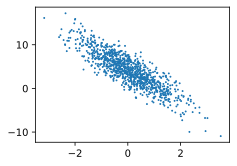

In [4]:
# plot of y vs x1:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

###3-1-1 everything by hand

In [5]:
# produce small batch based on generated data
def data_iter(batch_size, features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices=torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size=10
for X,y in data_iter(batch_size,features,labels):
    # first sample batch:
    print(X,'\n',y)
    break

tensor([[ 0.2794, -0.8663],
        [-0.0456,  1.2029],
        [-0.8156,  0.3746],
        [ 1.3440, -0.3971],
        [ 0.4119,  0.0911],
        [ 1.2006, -0.4727],
        [-0.8905,  0.2413],
        [ 0.9147,  0.2900],
        [ 2.1362,  1.0825],
        [-0.4060, -0.6904]]) 
 tensor([[7.7032],
        [0.0206],
        [1.3109],
        [8.2326],
        [4.7128],
        [8.2035],
        [1.6008],
        [5.0501],
        [4.7753],
        [5.7306]])


In [19]:
# inintial data:
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

In [8]:
# define linear regression model: y=w1*x1+w2*x2+b
def linreg(X,w,b):
    return torch.matmul(X,w)+b 

In [9]:
# define loss model: mean square
def squared_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [14]:
# small patch gradient decent:
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad/batch_size
            param.grad.zero_()

In [22]:
# traning process:
lr =0.02
num_epochs=10
net=linreg
loss=squared_loss
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_1=loss(net(features,w,b),labels)
        print(f'epoch {epoch+1},loss{float(train_1.mean()):f}')    

epoch 1,loss0.000051
epoch 2,loss0.000049
epoch 3,loss0.000049
epoch 4,loss0.000049
epoch 5,loss0.000049
epoch 6,loss0.000049
epoch 7,loss0.000049
epoch 8,loss0.000049
epoch 9,loss0.000049
epoch 10,loss0.000049


In [23]:
print (f'error in prediction in w:{ true_w - w.reshape(true_w.shape)}')
print (f'error in prediction in b:{ true_b - b}')

error in prediction in w:tensor([ 0.0007, -0.0003], grad_fn=<SubBackward0>)
error in prediction in b:tensor([0.0008], grad_fn=<RsubBackward1>)


###3-1-2 utilizing python libary

In [25]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

# target value and generate features
true_w=torch.tensor([3,-30.2])
true_b=4.2
features,labels=d2l.synthetic_data(true_w,true_b,1000)

In [26]:
# generate small batch of data in form of iterator:
def load_array(data_array,batch_size,is_train=True):
    dataset=data.TensorDataset(*data_array)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

batch_size=10
data_iter=load_array((features,labels),batch_size)
next(iter(data_iter))

[tensor([[-1.0569, -1.2620],
         [ 0.3608, -1.0582],
         [ 0.1021, -0.1221],
         [ 1.1205,  0.6061],
         [-0.3294, -1.3943],
         [ 0.5363, -0.6774],
         [-0.4045,  0.3959],
         [-1.3530, -0.5711],
         [ 0.2289, -0.2110],
         [ 2.2209,  0.2988]]), tensor([[ 39.1338],
         [ 37.2521],
         [  8.1900],
         [-10.7474],
         [ 45.3113],
         [ 26.2833],
         [ -8.9657],
         [ 17.4011],
         [ 11.2576],
         [  1.8475]])]

In [27]:
from torch import nn
# use linear network with 2 input and 1 output:
net=nn.Sequential(nn.Linear(2,1))
# initial w and b:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [28]:
# define loss and optimsize method:
loss=nn.MSELoss()
trainer=torch.optim.SGD(net.parameters(),lr=0.03)

In [30]:
# training process:
num_epochs=3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l=loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l=loss(net(features),labels)
    print(f'epoch{epoch+1}, loss {l:f}')    

epoch1, loss 0.000105
epoch2, loss 0.000106
epoch3, loss 0.000106


#3-2 SoftMax Regression

###3-2-0 data generation

In [31]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

In [33]:
# tranform img data form pil to float32 with ToTenser
# divide by 255 so all pixal has value in between 0 and 1
trans=transforms.ToTensor()
mnist_train=torchvision.datasets.FashionMNIST(root="../data",train=True,transform=trans,download=True)
mnist_test=torchvision.datasets.FashionMNIST(root="../data",train=False,transform=trans,download=True)
len(mnist_train),len(mnist_test)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



(60000, 10000)

In [34]:
# all img has 1 channel with height and with be 28
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [36]:
# function return the labels of selected labels:
def get_fashion_mnist_labels(labels):
    text_labels=['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels ]

In [37]:
# function visualize the data:
def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    figsize=(num_cols*scale,num_rows*scale)
    _,axes=d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    axes=axes.flatten()
    for i, (ax, img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

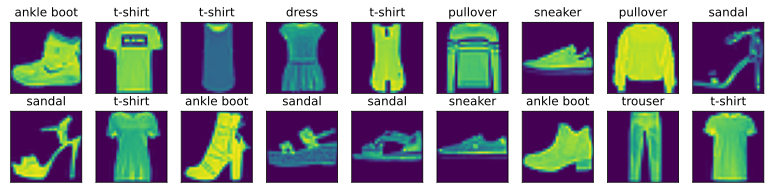

In [39]:
X,y=next(iter(data.DataLoader(mnist_train,batch_size=18)))
show_images(X.reshape(18,28,28),2,9,titles=get_fashion_mnist_labels(y))

In [46]:
batch_size=256
def get_dataloader_workers():
    return 4
train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [45]:
# time cost of reading data:
timer=d2l.Timer()
for X,y in train_iter:
    continue;
f'{timer.stop():.2f} sec'

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


'5.36 sec'

In [49]:
# function read and resize data return an iterator of batch data
def load_data_fashion_mnist(batch_size,resize=None):
    trans=[transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize))
    trans=transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [50]:
# test resize:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


###3-1-1 everthing by hand

In [51]:
import torch
from IPython import display
from d2l import torch as d2l
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [60]:
# initial weight and bias:
num_inputs=28*28
num_outputs=10
W=torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b=torch.zeros(num_outputs,requires_grad=True)

In [57]:
# sum along a dimension and keep the original size
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]), tensor([[ 6.],
         [15.]]))

In [58]:
# softmax normalization:
def softmax(X):
    X_exp=torch.exp(X)
    partition=X_exp.sum(1,keepdim=True)
    return X_exp/partition

X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1316, 0.0734, 0.1562, 0.0130, 0.6258],
         [0.1460, 0.0602, 0.3306, 0.0212, 0.4420]]), tensor([1., 1.]))

In [61]:
# define model: linear regression + softmax:
def net(X):
    return softmax(torch.matmul(X.reshape(-1,W.shape[0]),W)+b)

In [62]:
y=torch.tensor([0,2])
y_hat=torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
# pick the column value from y_hat based on index given by y:
y_hat[[0,1],y]

tensor([0.1000, 0.5000])

In [63]:
# cross entropy loss:
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])
cross_entropy(y_hat,y)

tensor([2.3026, 0.6931])

In [64]:
# evaluate the correctness of prediction:
def accuracy(y_hat,y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat=y_hat.argmax(axis=1)
    cmp=y_hat.type(y.dtype)==y
    return float(cmp.type(y.dtype).sum())
accuracy(y_hat,y)/len(y)

0.5

In [71]:
def evaluate_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module):
        net.eval()
    metric=d2l.Accumulator(2)
    for X,y in data_iter:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [67]:
def train_epoch_ch3(net, train_iter, loss, updater):  
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [68]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  
    """Train a model (defined in Chapter 3)."""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [69]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

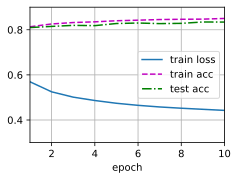

In [72]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


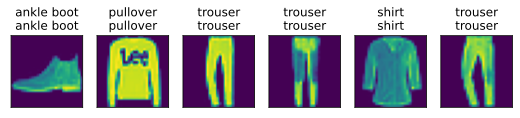

In [73]:
def predict_ch3(net, test_iter, n=6):  
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

### 3-1-2 utilizing python library

In [74]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [75]:
# PyTorch does not implicitly reshape the inputs. Thus we define the flatten
# layer to reshape the inputs before the linear layer in our network
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [76]:
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

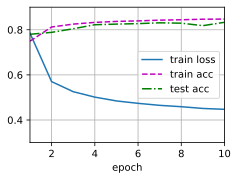

In [77]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)